In [1]:
#gather assess clean analyze model visualize
import pandas as pd
import numpy as np
import seaborn as sns
import re
from re import sub

import statistics
from string import punctuation

In [2]:
exec(open("./randomforestfunctions.py").read())

In [3]:
exec(open("./fancy_string.py").read())

In [4]:
def to_money(val):
    '''
    INPUT:
    str formatted $1,000.00 indicating monetary value 
    
    OUTPUT:
    float of monetary value
    '''
    val = val[1:len(val)-3]
    val = val.replace(',', '')
    return(float(val))

def col_to_money(colname, df):
    return ([to_money(i) if isinstance(i, float) == False else None for i in df[colname]])

def col_from_percent(colname, df)
    return([float(i.replace('%', ''))if isinstance(i, float) == False else None for i in df[colname]])
    
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1),dums], axis=1)
        except:
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        for n in i:
            if n not in column_names:
                column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def text_to_cols(colname, df):
    '''
    INPUT:
    str column name and dataframe that contains it 
    
    OUTPUT:
    dataframe with new columns containing str properties, original str column removed
    '''
    fancy_strings = [FancyString(i) for i in df[colname]]
    df[colname + '_adcount'] = [i.ad_count() for i in fancy_strings]
    df[colname + '_wordcount'] = [i.wordcount() for i in fancy_strings]
    df = df.drop(colname, axis = 1)
    return(df)

In [20]:
#gather
listings = pd.read_csv('./listings.csv', index_col = 0).reset_index()
reviews = pd.read_csv('./reviews.csv', index_col = 0).reset_index()
full_df = reviews.merge(listings, left_on = 'listing_id', right_on = 'id', how = 'inner')

In [6]:
#assess
print(full_df.shape)
print("\n")
print(full_df.info())
print(full_df.describe())

(68275, 101)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68275 entries, 0 to 68274
Columns: 101 entries, listing_id to reviews_per_month
dtypes: float64(18), int64(18), object(65)
memory usage: 53.1+ MB
None
         listing_id          id_x   reviewer_id          id_y     scrape_id  \
count  6.827500e+04  6.827500e+04  6.827500e+04  6.827500e+04  6.827500e+04   
mean   4.759910e+06  5.246516e+07  2.802389e+07  4.759910e+06  2.016091e+13   
std    3.788990e+06  2.790991e+07  2.234097e+07  3.788990e+06  6.585986e+00   
min    3.353000e+03  1.021000e+03  1.430000e+02  3.353000e+03  2.016091e+13   
25%    1.458081e+06  3.010420e+07  9.001346e+06  1.458081e+06  2.016091e+13   
50%    4.080000e+06  5.223121e+07  2.305179e+07  4.080000e+06  2.016091e+13   
75%    7.377034e+06  7.663248e+07  4.213454e+07  7.377034e+06  2.016091e+13   
max    1.484378e+07  9.999045e+07  9.335034e+07  1.484378e+07  2.016091e+13   

            host_id  host_listings_count  host_total_listings_count  \
c

In [21]:
#clean
#eliminate any fully empty rows or columns and retain an item-level index
full_df = full_df.dropna(axis = 0, how = 'all')
full_df = full_df.dropna(axis = 1, how = 'all')

In [ ]:
money_col_list = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

for i in money_col_list:
    full_df[i + '_float'] = col_to_money(i, full_df)
    
percent_col_list = ['host_response_rate', 'host_acceptance_rate']

for i in percent_col_list:
    full_df[i] = col_from_percent(i, full_df)

In [22]:
full_df['amenities'] = [re.findall('"([^"]*)"', i) if isinstance(i, float) == False else None for i in full_df['amenities']]
amenities = list_to_cols(full_df['amenities'])
amenities = amenities[amenities.columns.drop(list(amenities.filter(regex='translation missing')))]

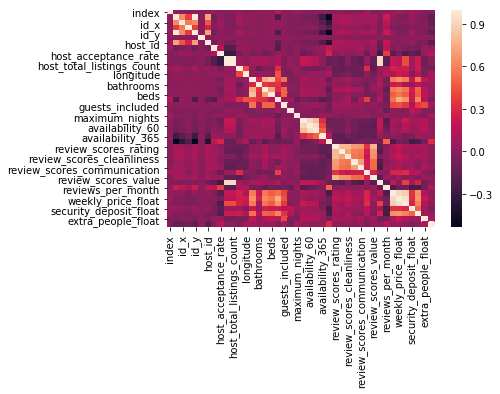

In [9]:
num_df = full_df.select_dtypes(include=['float64', 'int64']).copy().reset_index(drop = True)
sns.heatmap(num_df.corr(), annot=False, fmt=".2f");

In [10]:
#clean
text_cols = ['comments', 'name', 'summary', 'space', 'description','house_rules']
txt_df = full_df[text_cols].copy()

for i in text_cols:
    txt_df = text_to_cols(i, txt_df)

In [12]:
txt_df.to_csv('./txt_df.csv')

In [41]:
txt_df = txt_df.drop(txt_df.columns[0], axis=1)

In [23]:
bad_objs = "calendar_updated price extra_people smart_location cleaning_fee security_deposit amenities first_review last_review city zipcode weekly_price neighbourhood_cleansed host_since monthly_price calendar_last_scraped date reviewer_name listing_url neighborhood_overview last_scraped experiences_offered notes transit access interaction thumbnail_url medium_url picture_url xl_picture_url host_url host_name host_location host_about host_thumbnail_url host_picture_url host_neighbourhood host_verifications host_has_profile_pic street neighbourhood"
bad_objL = bad_objs.split()

obj_df = full_df.select_dtypes(include=['object']).copy()
obj_df = obj_df.drop(text_cols, axis = 1)
obj_df = obj_df.drop(bad_objL, axis = 1)

In [27]:
obj_df =create_dummy_df(obj_df,list(obj_df.columns), True)
obj_df = obj_df.reset_index(drop = True)
obj_df2 = pd.concat([obj_df, amenities], axis = 1)

obj_df2 = obj_df2[obj_df2.columns.drop(list(obj_df2.filter(regex='index')))]


In [42]:
clean_df = pd.concat([num_df, obj_df], axis = 1)
clean_df = clean_df[clean_df.columns.drop(list(clean_df.filter(regex='_id')))]

clean_df['listing_id'] = full_df['listing_id']
clean_df = pd.concat([clean_df, txt_df], axis = 1)
clean_df = clean_df.loc[:, (clean_df != 0).any(axis=0)]

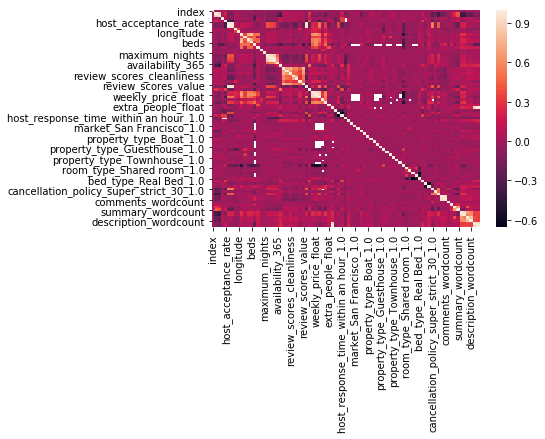

In [45]:
sns.heatmap(clean_agg.corr(), annot=False, fmt=".2f");

In [43]:
clean_agg = clean_df.groupby('listing_id').agg('mean').reset_index(drop = True)

In [46]:
fillmean = lambda col: col.fillna(col.mean())

clean_agg = clean_agg.dropna(subset = ['price_float'], axis = 0)
X = clean_agg.copy().drop(['price_float','index', 'monthly_price_float','weekly_price_float'], axis = 1)
X = X.apply(fillmean)
y = clean_agg['price_float'].ravel()

In [47]:
best_param = specify_best(model = RandomForestRegressor(random_state = 15), typ = 'RF', X = X, y = y)

rf = RandomForestRegressor(min_samples_split=best_param.get('min_samples_split'), 
                           max_features= best_param.get('max_features'),random_state = 15)

{'max_features': 14, 'min_samples_split': 7}


In [ ]:
rf_res = run_each_participant(rf, X, y, feat_bool = True)
eprf = ext_featEPRF(rf_res[2], mean = True)
print_vals(best_param, rf_res, eprf)

In [29]:
clean_df

,index,listing_id,id_x,reviewer_id,id_y,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,...,name_adcount,name_wordcount,summary_adcount,summary_wordcount,space_adcount,space_wordcount,description_adcount,description_wordcount,house_rules_adcount,house_rules_wordcount
0,0,1178162,4724140,4298113,1178162,20160906204935,1407005,100.0,97.0,4,...,1,5,0,1,16,186,16,186,10,101
1,1,1178162,4869189,6452964,1178162,20160906204935,1407005,100.0,97.0,4,...,1,5,0,1,16,186,16,186,10,101
2,2,1178162,5003196,6449554,1178162,20160906204935,1407005,100.0,97.0,4,...,1,5,0,1,16,186,16,186,10,101
3,3,1178162,5150351,2215611,1178162,20160906204935,1407005,100.0,97.0,4,...,1,5,0,1,16,186,16,186,10,101
4,4,1178162,5171140,6848427,1178162,20160906204935,1407005,100.0,97.0,4,...,1,5,0,1,16,186,16,186,10,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68270,68270,7462268,80537457,22034145,7462268,20160906204935,19548932,100.0,100.0,8,...,1,9,5,76,4,61,12,179,3,25
68271,68271,7462268,83640094,40052513,7462268,20160906204935,19548932,100.0,100.0,8,...,1,9,5,76,4,61,12,179,3,25
68272,68272,7462268,85797088,77129134,7462268,20160906204935,19548932,100.0,100.0,8,...,1,9,5,76,4,61,12,179,3,25
68273,68273,7462268,97264637,15799803,7462268,20160906204935,19548932,100.0,100.0,8,...,1,9,5,76,4,61,12,179,3,25
